## Base Class for All Graph Simulations

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

class GraphPlotter:
  def __init__(self, filename='graph_print.pdf', figsize=(12, 8)):
    self.HIGHLIGHT_COLOR = '#e31a1c'
    self.VISITED_COLOR = '#5fe382'
    self.NEUTRAL_COLOR = '#1f78b4'
    self.filename = filename
    self.figsize = figsize
    self.graph = nx.Graph()
    self.node_color = []

  def color_visited(self, node):
    self.node_color[node] = self.VISITED_COLOR

  def highlight_node(self, node):
    self.node_color[node] = self.HIGHLIGHT_COLOR

  def draw(self):
    fig = plt.figure(figsize=(12, 8))
    fig = nx.draw(self.graph, node_color=self.node_color, with_labels=True, font_weight='bold')
    return fig

  def print_pdf(self, algorithm, params=[]):
    self.output = PdfPages(self.filename)
    self.setup(params)

    algorithm(self, params)

    self.output.close()


## Original Pyramid Scheme - The "eight ball" model

Cada investidor entra com um aporte de $5000 e recebe $5000 de cada investidor que entrar no esquema 3 gerações abaixo dele.

In [ ]:
# %%capture
import numpy as np
from queue import Queue

class EightBallPlotter(GraphPlotter):
  def setup(self, params):
    gen = nx.fast_gnp_random_graph(params[0], 0.15)
    self.graph.add_nodes_from(sorted(gen.nodes(data=True)))
    self.graph.add_edges_from(gen.edges(data=True))
    self.node_color = ['#1f78b4'] * len(self.graph.nodes)
    self.tree = nx.DiGraph()
    self.tree.add_nodes_from(sorted(gen.nodes(data=True)))

  def draw_graph(self):
    fig = plt.figure(figsize=self.figsize)
    fig.set_figwidth(self.figsize[0] - 1.3)
    fig.set_figheight(self.figsize[1] - 1)

    text = f'Grafo Aleatório Original\n\n' + \
    f'Ordem: {len(self.graph.nodes)}\n' + \
    f'Tamanho: {len(self.graph.edges)}\n' + \
    f'Coeficiente de Aglomeração: {nx.average_clustering(self.graph)}\n' + \
    f'Grau Médio: {np.mean([self.graph.degree(node) for node in self.graph.nodes])}\n' + \
    f'\nLegenda:\n' + \
    f'Vermelho: Investidor que entrou no esquema\n' + \
    f'Verde: Investidor que já recebeu dinheiro\n' + \
    f'Azul: Investidor fora do esquema\n' + \
    f'\nCada investidor entra com um aporte de \$5000\ne recebe \$5000 de cada investidor que entrar no esquema 3 gerações abaixo dele\n'

    plt.figtext(0.0, 0.67, text, fontsize=14, bbox={"facecolor":"orange", "alpha":0.75, "pad":5})
    fig = nx.draw(self.graph, node_color=self.node_color, with_labels=True, font_weight='bold')
    
    return fig

  def draw_tree(self, layer=None):
    fig = plt.figure(figsize=self.figsize)

    if layer != None:
      plt.text(0.025, 0.95, f'Árvore do Modelo das "Oito Bolas" - {len(self.graph.nodes)} Nós\nCamada Atual: {layer}', transform = fig.transFigure, size=14)

    fig = nx.draw(self.tree, node_color=self.node_color, pos=nx.nx_agraph.graphviz_layout(self.tree, prog='dot'), with_labels=True, font_weight='bold')

    graph_data = sorted(self.tree.nodes(data=True), key=lambda x: x[1]['balance'], reverse=True)[0:64]
    data_text = ''
    for index, node in enumerate(graph_data):
      data_text += f'{node[0]}: \${node[1]["balance"]}'
      if (index + 1) % 2 == 0:
        data_text += f'\n'
      else:
        data_text += f' | '
    plt.figtext(0.01, 0.01, data_text, fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    return fig

  def graph_callback(self):
    self.output.savefig(self.draw_graph(), bbox_inches='tight')
  
  def tree_callback(self, layer=None):
    self.output.savefig(self.draw_tree(layer), bbox_inches='tight')

def eight_ball_model(graph_plotter, params):
  ORIGIN = 0
  graph = graph_plotter.graph
  tree = graph_plotter.tree

  for i in graph.nodes():
    graph.nodes[i]['visited'] = False
    tree.nodes[i]['balance'] = 0
    
  node_queue = Queue()
  node_queue.put(ORIGIN)
  graph.nodes[ORIGIN]['visited'] = True

  graph_plotter.graph_callback()
    
  def distance_to_origin(node, distance=0):
    if node == ORIGIN:
      return distance
    else:
      return 1 + distance_to_origin(list(tree.predecessors(node))[0])

  layer = 0
  def payment(investor, receiver, parent=3):
    if parent == 0 or not list(tree.predecessors(receiver)):
      tree.nodes[receiver]['balance'] += 5000
      tree.nodes[investor]['balance'] -= 5000
      graph_plotter.color_visited(receiver)
      graph_plotter.highlight_node(investor)
      return 0
    else:
      return payment(investor, list(tree.predecessors(receiver))[0], parent - 1)
  
  while not node_queue.empty():
    current_node = node_queue.get()
    if distance_to_origin(current_node) > layer:
      layer += 1
      graph_plotter.tree_callback(layer=layer)

    payment(current_node, current_node)

    non_visited_neighbors = list(filter(lambda node: not graph.nodes[node]['visited'], list(graph.neighbors(current_node))))
    drafted_neighbors = np.random.choice(non_visited_neighbors, size=min(2, len(non_visited_neighbors)), replace=False)

    for i in drafted_neighbors:
      node_queue.put(i)
      graph.nodes[i]['visited'] = True
      tree.add_edge(current_node, i)
  graph_plotter.tree_callback(layer=layer+1)

EightBallPlotter('output/eight_ball_model.pdf', figsize=(12, 8)).print_pdf(eight_ball_model, [128])

## Ponzi Scheme

Em um esquema Ponzi, os participantes recebem a promessa de retornos de "investimentos", supostamente em ações ou bens, mas que na verdade são pagos por novos investidores, enquanto uma figura central principal recebe uma parte como lucro.

### Simulação

Para a simulação, cada investidor entra no esquema com um aporte inicial entre $500 e $50000, 10% do aporte é destinado ao topo da pirâmide(representando o saque para uso pessoal do criador do esquema), o restante vai para o **montante** que é distribuído entre os investidores das gerações descendentes do topo recursivamente. Por cada investidor que a recursão do pagamento passar, o investidor recebe 10% do **montante** restante(limitado até 150% do aporte inicial do investidor pago, valor que representa o investimento prometido pelo esquema) e a recursão continua com seus descendentes. A recursão para quando o **montante** restante chega a $0 ou quando não há mais descendentes para receber o pagamento.

Essa simulação desconsidera a possibilidade de um investidor reinvestir o dinheiro recebido no esquema, o que aumentaria o lucro do topo da pirâmide.

c:\ProgramData\Anaconda3\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: Could not load "C:\ProgramData\Anaconda3\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


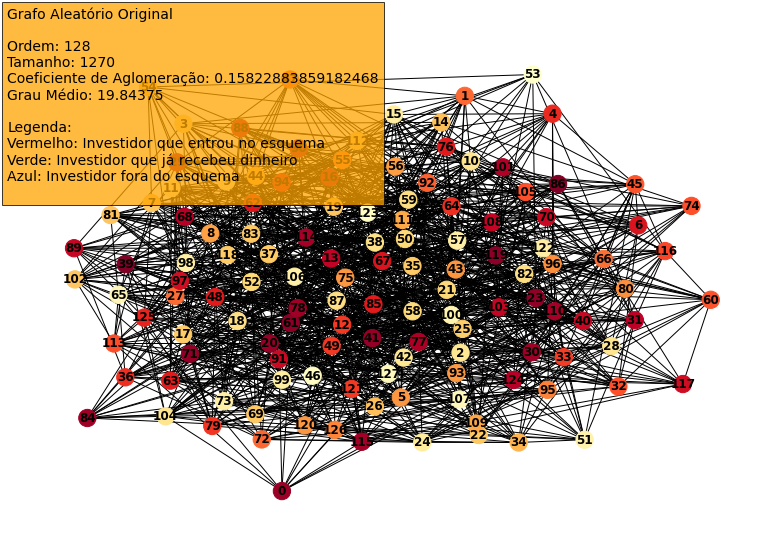

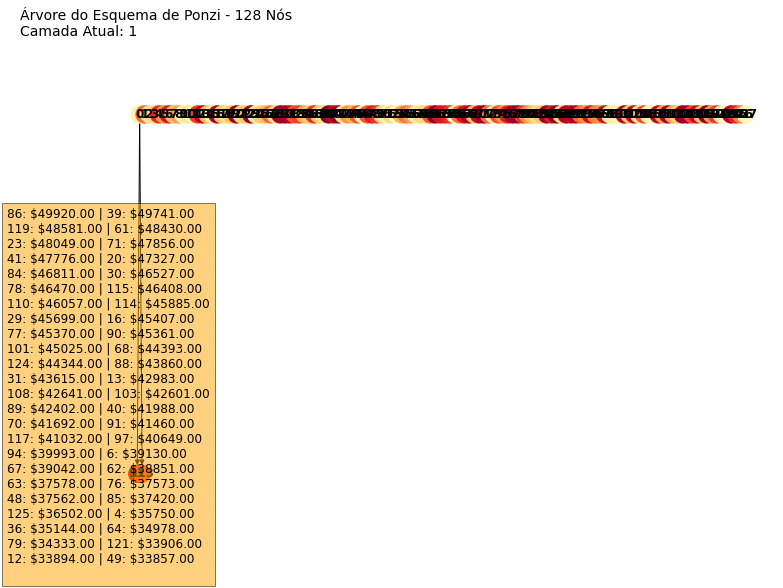

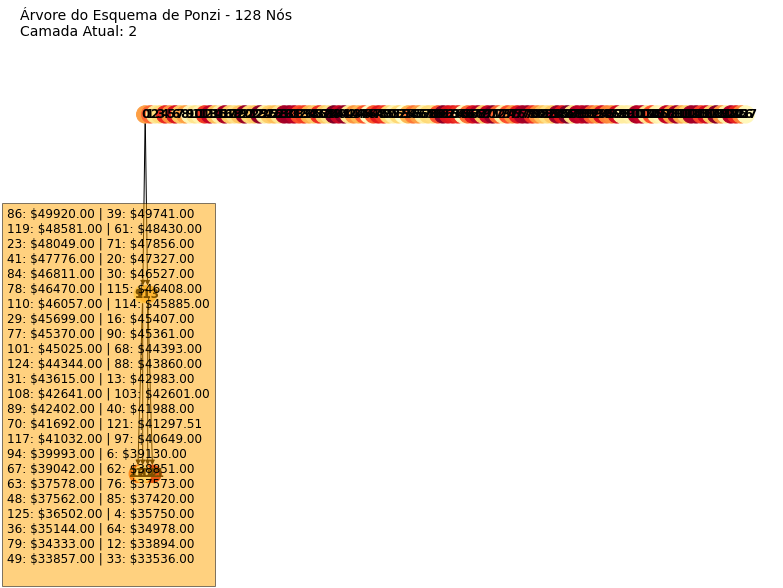

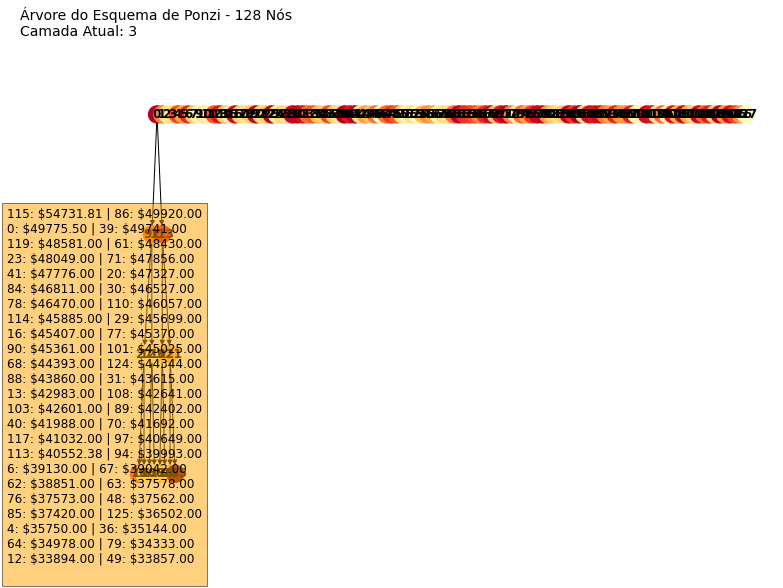

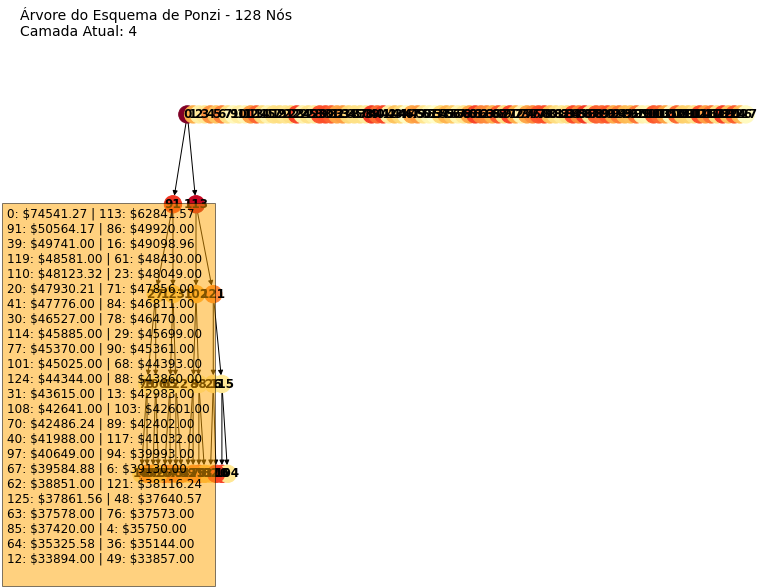

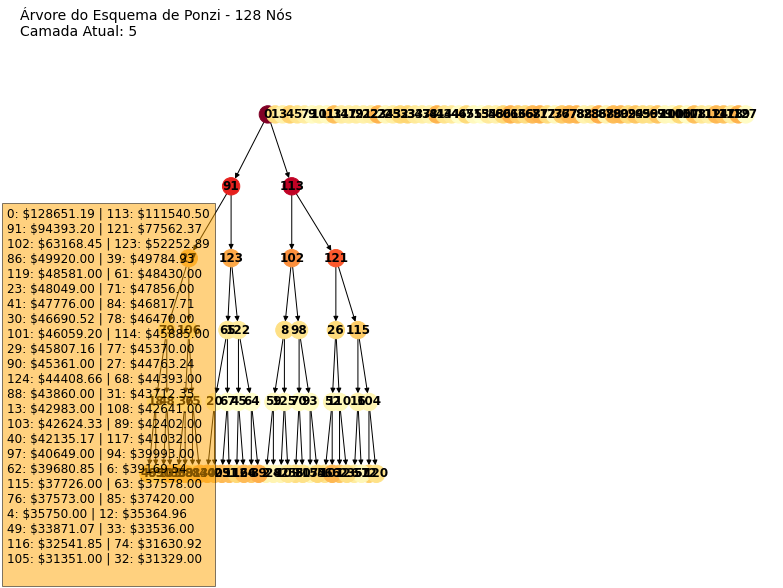

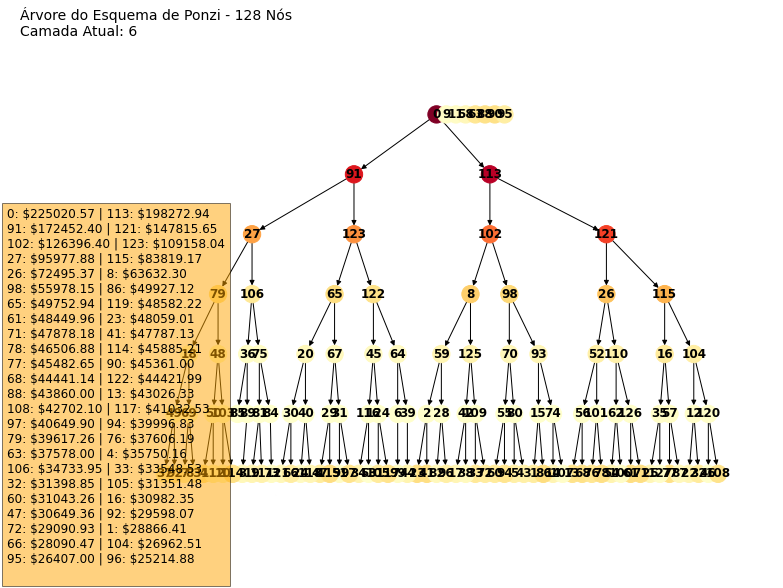

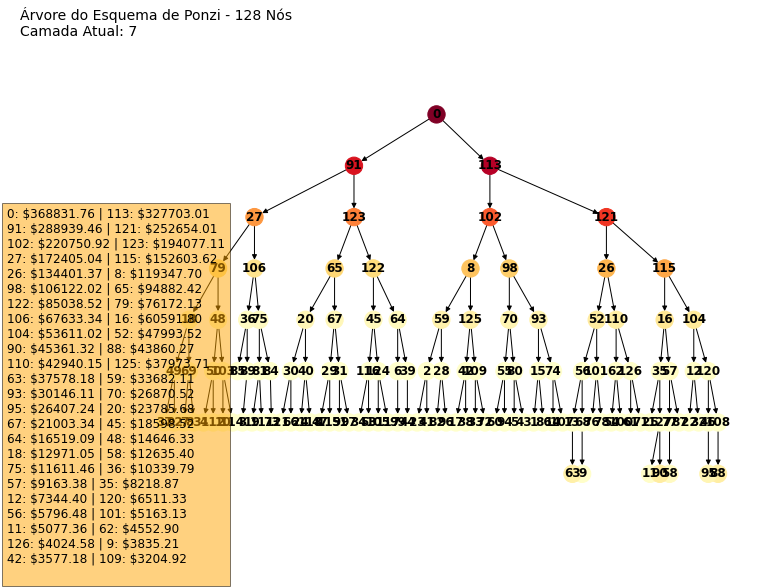

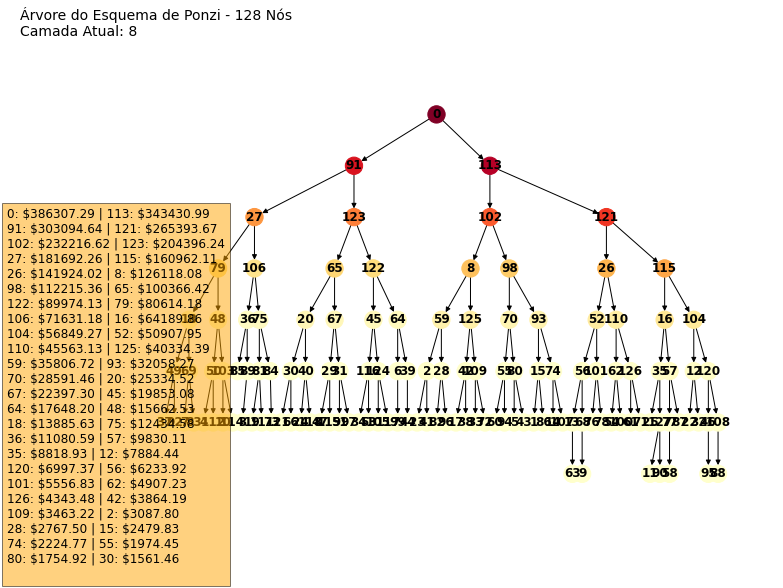

In [28]:
import pandas
import numpy as np
from queue import Queue

class InvestmentSchemePlotter(GraphPlotter):
  def setup(self, params):
    self.color_map = 'YlOrRd'
    gen = nx.fast_gnp_random_graph(params[0], 0.15)
    self.graph.add_nodes_from(sorted(gen.nodes(data=True)))
    self.graph.add_edges_from(gen.edges(data=True))
    self.node_color = ['#1f78b4'] * len(self.graph.nodes)
    self.tree = nx.DiGraph()
    self.tree.add_nodes_from(sorted(gen.nodes(data=True)))

  def draw_graph(self):
    fig = plt.figure(figsize=self.figsize)
    fig.set_figwidth(self.figsize[0] - 1.3)
    fig.set_figheight(self.figsize[1] - 1)

    text = f'Grafo Aleatório Original\n\n' + \
    f'Ordem: {len(self.graph.nodes)}\n' + \
    f'Tamanho: {len(self.graph.edges)}\n' + \
    f'Coeficiente de Aglomeração: {nx.average_clustering(self.graph)}\n' + \
    f'Grau Médio: {np.mean([self.graph.degree(node) for node in self.graph.nodes])}\n' + \
    f'\nLegenda:\n' + \
    f'Vermelho: Investidor que entrou no esquema\n' + \
    f'Verde: Investidor que já recebeu dinheiro\n' + \
    f'Azul: Investidor fora do esquema\n'

    plt.figtext(0.0, 0.67, text, fontsize=14, bbox={"facecolor": "orange", "alpha": 0.75, "pad": 5})
    fig = nx.draw(self.graph, node_color=list(map(lambda x: x[1]['balance'], self.tree.nodes(data=True))), cmap=plt.get_cmap(self.color_map), with_labels=True, font_weight='bold')

    return fig

  def draw_tree(self, layer=None):
    fig = plt.figure(figsize=self.figsize)

    if layer is not None:
      plt.text(0.025, 0.95, f'Árvore do Esquema de Ponzi - {len(self.graph.nodes)} Nós\nCamada Atual: {layer}',
              transform=fig.transFigure, size=14)

    fig = nx.draw(self.tree, node_color=list(map(lambda x: x[1]['balance'], self.tree.nodes(data=True))),
                  pos=nx.nx_agraph.graphviz_layout(self.tree, prog='dot'),
                  cmap=plt.get_cmap(self.color_map), with_labels=True, font_weight='bold')

    graph_data = sorted(self.tree.nodes(data=True), key=lambda x: x[1]['balance'], reverse=True)[0:48]
    data_text = ''
    for index, node in enumerate(graph_data):
      data_text += f'{node[0]}: \${node[1]["balance"]:.2f}'
      if (index + 1) % 2 == 0:
        data_text += f'\n'
      else:
        data_text += f' | '
    plt.figtext(0.01, 0.01, data_text, fontsize=12, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})

    return fig

  def graph_callback(self):
    self.output.savefig(self.draw_graph(), bbox_inches='tight')

  def tree_callback(self, layer=None):
    self.output.savefig(self.draw_tree(layer), bbox_inches='tight')


def ponzi_scheme_model(graph_plotter, params):
  ORIGIN = 0
  graph = graph_plotter.graph
  tree = graph_plotter.tree

  for i in graph.nodes():
    graph.nodes[i]['visited'] = False
    tree.nodes[i]['balance'] = np.random.randint(500, 50000)  # Initial contribution between $500 and $500000
    tree.nodes[i]['initial_investment'] = tree.nodes[i]['balance'] 

  amount = 0

  node_queue = Queue()
  node_queue.put(ORIGIN)
  graph.nodes[ORIGIN]['visited'] = True

  graph_plotter.graph_callback()

  def distance_to_origin(node, distance=0):
    if node == ORIGIN:
      return distance
    else:
      return 1 + distance_to_origin(list(tree.predecessors(node))[0])


  def payment():
    nonlocal amount
    payment_queue = Queue()
    payment_queue.put(ORIGIN)

    while not payment_queue.empty():
        if amount <= 0:
            break
        node = payment_queue.get()

        tree.nodes[node]['balance'] += amount * 0.1
        amount -= amount * 0.1
        if tree.neighbors(node):
            for neighbor in tree.neighbors(node):
                payment_queue.put(neighbor)

  layer = 0
  while(not node_queue.empty()):
    current_node = node_queue.get()
    if(distance_to_origin(current_node) > layer):
      layer += 1
      graph_plotter.tree_callback(layer=layer)

    amount += tree.nodes[current_node]['balance']
    tree.nodes[current_node]['balance'] = 0
    payment()

    non_visited_neighbors = list(filter(lambda node: not graph.nodes[node]['visited'],
                                  list(graph.neighbors(current_node))))
    drafted_neighbors = np.random.choice(non_visited_neighbors, size=min(2, len(non_visited_neighbors)),
                                         replace=False)

    for i in drafted_neighbors:
      node_queue.put(i)
      graph.nodes[i]['visited'] = True
      tree.add_edge(current_node, i)

  graph_plotter.tree_callback(layer=layer + 1)


InvestmentSchemePlotter('output/ponzi_scheme_model.pdf', figsize=(12, 8)).print_pdf(ponzi_scheme_model, [128])